In [1]:
import cv2
import joblib
import pandas as pd 
import numpy as np
import albumentations as A
import keras.backend as K
from time import time
from random import seed
from tensorflow import keras 
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.metrics import Precision, BinaryAccuracy, Recall
from keras.utils.vis_utils import plot_model
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
DATA_PATH = './data'
def load_dataset():
    X_yes = np.load(f'{DATA_PATH}/def_yes_images.npy')
    X_no = np.load(f'{DATA_PATH}/def_no_images.npy')
    classes = np.load(f'{DATA_PATH}/classes.npy')

    print(f'X_yes shape: {X_yes.shape}')
    print(f'X_no shape {X_no.shape}')
    print(f'classes shape: {classes.shape}')

    return X_yes, X_no, classes

def reshape_dataset(X_yes, X_no):
    X = np.row_stack((X_yes, X_no))
    N, SIZE_H, SIZE_V = X.shape
    X = np.reshape(X, newshape=(N, SIZE_H * SIZE_V))x = 
    print(f'X shape: {X.shape}')
    return X

def data_augmentation(imgs, classes, aug_per_image, imgs_trans):
    new_images, new_classes = [], []
    for img, y, i in zip(imgs, classes, range(1, len(imgs) + 1)):
        for _ in range(aug_per_image):
            tmp_img = imgs_trans(image=img)["image"]
            new_images.append(tmp_img)
            new_classes.append(y)
        if i % 50 == 0: print(f'[!] {i} images agumented...')
    print(f'[!] Total of {len(imgs)} images augmented!\n')
    return new_images, new_classes

def sensitivity(y_true, y_pred):
    # tp/(fn + tp)
    y_true_tmp = y_true.numpy()
    y_pred_tmp = y_pred.numpy()
    tp = y_true[y_true_tmp == y_pred_tmp]
    tp = len(tp[tp == 1])
    fn = y_pred[y_true_tmp != y_pred_tmp]
    fn = len(fn[fn == 0])
    return tp / (tp + fn)


def specificity(y_true, y_pred):
    # tn / (fp + tn)
    y_true_tmp = y_true.numpy()
    y_pred_tmp = y_pred.numpy()
    tn = y_true[y_true_tmp == y_pred_tmp]
    tn = len(tn[tn == 0])
    fp = y_pred[y_true_tmp != y_pred_tmp]
    fp = len(fp[fp == 1])
    return tn / (tn + fp)

def balanced_acc(sensitivity, specificity):
    return (sensitivity + specificity) / 2.0

In [3]:
X_yes, X_no, classes = load_dataset()
X = np.row_stack((X_yes, X_no))
N, SIZE_H, SIZE_V = X.shape
N_CLASSES = len(np.unique(classes))
print(f'X shape {X.shape}')
print(f'Num classes: {N_CLASSES}')

X_yes shape: (134, 224, 224)
X_no shape (86, 224, 224)
classes shape: (220,)
X shape (220, 224, 224)
Num classes: 2


In [4]:
sd = seed(time())
X_train, X_test, y_train, y_test = train_test_split(X, classes, test_size=0.3, random_state=sd, shuffle=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 32)      832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 109, 109, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 186624)            0         
                                                                 
 dense (Dense)               (None, 120)               2

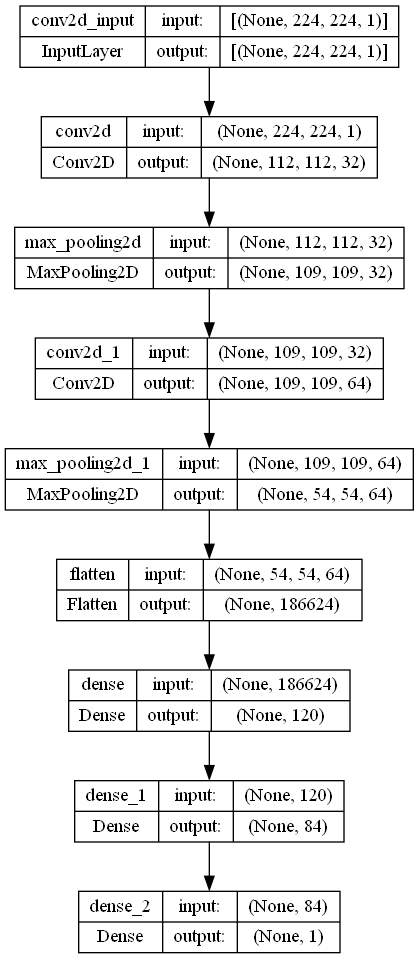

In [5]:
le_net_5 = keras.Sequential([
    # LAYER 1
    Conv2D(filters=32, kernel_size=(5, 5), strides=2, padding="same", input_shape=(SIZE_H, SIZE_V, 1), activation='relu'),
    MaxPooling2D(pool_size=(4, 4), strides=1, padding="valid"),
    # LAYER 2
    Conv2D(filters=64, kernel_size=(5, 5), strides=1, padding="same", activation='relu'),
    MaxPooling2D(pool_size=(3, 3), strides=2, padding="valid"),
    # FLATTEN
    Flatten(),
    # DENSE LAYERS
    Dense(units=120, activation='relu'),
    Dense(units=84, activation='relu'),
    # OUTPUT
    Dense(units=1, activation='sigmoid')
])

print(le_net_5.summary())
plot_model(le_net_5, show_shapes=True, show_layer_names=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 224, 224, 64)      640       
                                                                 
 conv2d_3 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_5 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                  

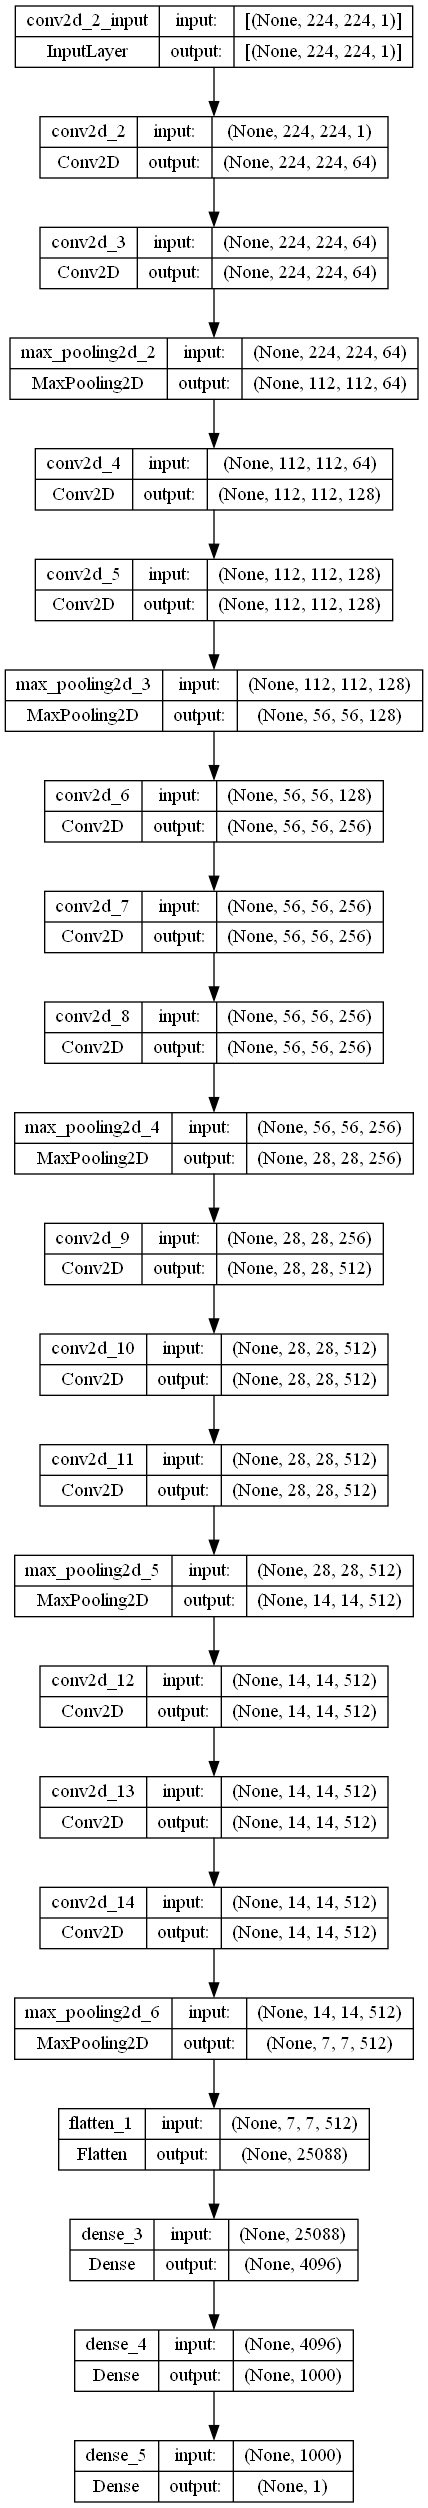

In [6]:
vgg_16 = keras.Sequential([
    # LAYER 1
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', input_shape=(SIZE_H, SIZE_V, 1), activation='relu'),
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    # LAYER 2
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=128, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    Conv2D(filters=128, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    # LAYER 3
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=256, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    Conv2D(filters=256, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    Conv2D(filters=256, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    # LAYER 4
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    # LAYER 5
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    # MAXPOOL BEFORE FC
    MaxPooling2D(pool_size=(2, 2), strides=2),
    # FULLY CONNECTED LAYERS
    Flatten(),
    Dense(units=4096, activation='relu'),
    Dense(units=1000, activation='relu'),
    # OUTPUT LAYER
    Dense(units=1, activation='sigmoid')
])

print(vgg_16.summary())
plot_model(vgg_16, show_shapes=True, show_layer_names=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 224, 224, 32)      320       
                                                                 
 conv2d_16 (Conv2D)          (None, 224, 224, 32)      9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_17 (Conv2D)          (None, 112, 112, 64)      18496     
                                                                 
 conv2d_18 (Conv2D)          (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                  

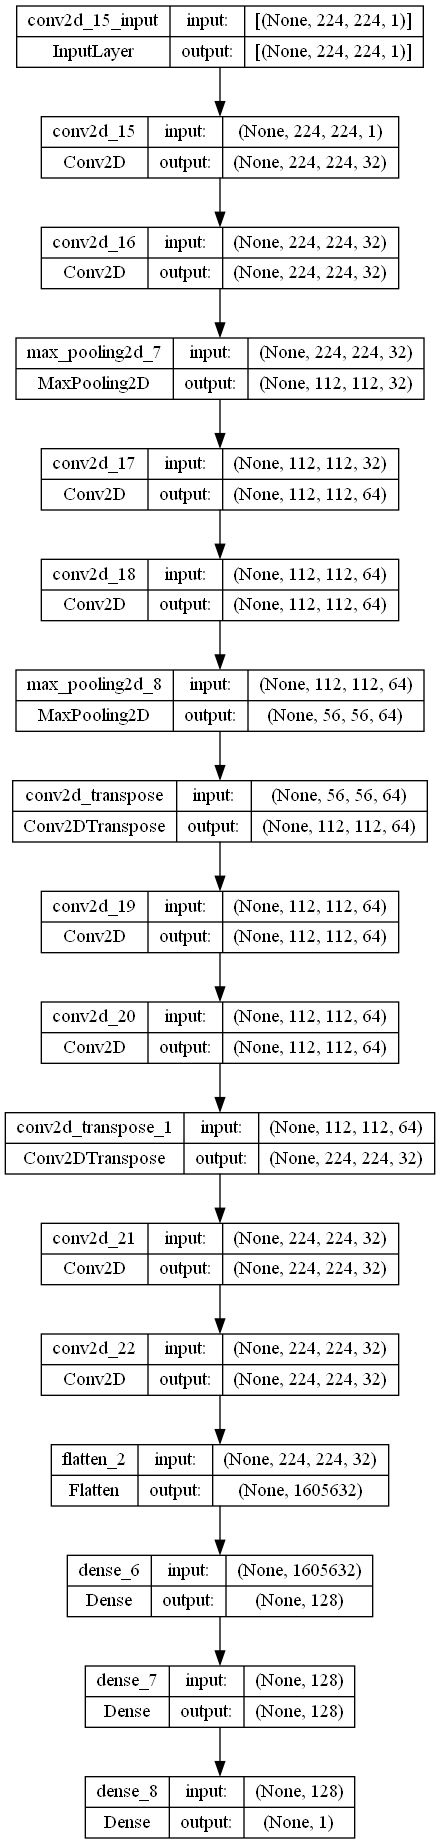

In [7]:
lu_net = keras.Sequential([
    # LAYER 1
    Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding='same', input_shape=(SIZE_H, SIZE_V, 1), activation='elu'),
    Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding='same', activation='elu'),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    # LAYER 2
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='elu'),
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='elu'),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    # LAYER 3
    Conv2DTranspose(filters=64, kernel_size=(2, 2), strides=2, padding='same', activation='elu'),
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='elu'),
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='elu'),
    # LAYER 4
    Conv2DTranspose(filters=32, kernel_size=(2, 2), strides=2, padding='same', activation='elu'),
    Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding='same', activation='elu'),
    Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding='same', activation='elu'),
    # Fully connected layers
    Flatten(),
    Dense(units=128, activation='sigmoid'),
    Dense(units=128, activation='sigmoid'),
    # OUTPUT
    Dense(units=1, activation='sigmoid')
])

print(lu_net.summary())
plot_model(lu_net, show_shapes=True, show_layer_names=True)

In [8]:
#opt = keras.optimizers.Adam(learning_rate=0.0003)
METRICS = [
    Precision(),
    BinaryAccuracy(),
    Recall(),
    sensitivity,
    specificity
]

le_net_5.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)
vgg_16.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)
lu_net.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)

In [9]:
# le_net_5_k = KerasClassifier(le_net_5, epochs=100, batch_size=20, verbose=2)
# vgg_16_k = KerasClassifier(vgg_16, epochs=100, batch_size=20, verbose=2)
# lu_net_k = KerasClassifier(lu_net, epochs=100, batch_size=20, verbose=2)

# sd = seed(time())
# RSKFold = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=sd)

In [10]:
def fit_evaluate(model, X_train, X_test, y_train, y_test, batch_size=32, epochs=100, validation_split=0.2):
    res_model = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=validation_split)
    scores_model =model.evaluate(X_test, y_test)
    return res_model, scores_model

def graph_history(df, metrics):
    fig, ax = plt.subplots(nrows=1, ncols=3, sharex=True, figsize=(30, 10))
    for i, metric in zip(range(3), metrics):
        ax[i].plot(range(1, 101), df[metric], 'b-', label='Train')
        ax[i].plot(range(1, 101), df[f'val_{metric}'], 'r-', label='Validation')
        ax[i].set_title(metric)
        ax[i].legend()
    plt.show()

In [11]:
res_le_net, scores_le_net = fit_evaluate(le_net_5, X_train, X_test, y_train, y_test)

Epoch 1/100
4/4 [==============================] - 10s 2s/step - loss: 447.5274 - precision: 0.6441 - binary_accuracy: 0.5366 - recall: 0.5135 - val_loss: 115.6022 - val_precision: 0.6129 - val_binary_accuracy: 0.6129 - val_recall: 1.0000
Epoch 2/100
4/4 [==============================] - 6s 2s/step - loss: 42.1294 - precision: 0.6066 - binary_accuracy: 0.6098 - recall: 1.0000 - val_loss: 0.7953 - val_precision: 1.0000 - val_binary_accuracy: 0.4516 - val_recall: 0.1053
Epoch 3/100
4/4 [==============================] - 6s 1s/step - loss: 0.7542 - precision: 1.0000 - binary_accuracy: 0.4715 - recall: 0.1216 - val_loss: 0.7024 - val_precision: 1.0000 - val_binary_accuracy: 0.4194 - val_recall: 0.0526
Epoch 4/100
4/4 [==============================] - 6s 2s/step - loss: 0.6651 - precision: 0.8529 - binary_accuracy: 0.5935 - recall: 0.3919 - val_loss: 0.6872 - val_precision: 0.5385 - val_binary_accuracy: 0.4194 - val_recall: 0.3684
Epoch 5/100
4/4 [==============================] - 6s 2s/s

In [12]:
res_vgg_16, scores_vgg_16 = fit_evaluate(vgg_16, X_train, X_test, y_train, y_test)

Epoch 1/100
4/4 [==============================] - 66s 15s/step - loss: 418.4660 - precision: 0.6875 - binary_accuracy: 0.5820 - recall: 0.5739 - val_loss: 2.2155 - val_precision: 0.6129 - val_binary_accuracy: 0.6129 - val_recall: 1.0000
Epoch 2/100
4/4 [==============================] - 55s 14s/step - loss: 1.3419 - precision: 0.6250 - binary_accuracy: 0.4634 - recall: 0.2703 - val_loss: 0.6956 - val_precision: 0.0000e+00 - val_binary_accuracy: 0.3871 - val_recall: 0.0000e+00
Epoch 3/100
4/4 [==============================] - 52s 13s/step - loss: 0.6946 - precision: 0.5185 - binary_accuracy: 0.4065 - recall: 0.1892 - val_loss: 0.6912 - val_precision: 0.6129 - val_binary_accuracy: 0.6129 - val_recall: 1.0000
Epoch 4/100
4/4 [==============================] - 51s 13s/step - loss: 0.6888 - precision: 0.6016 - binary_accuracy: 0.6016 - recall: 1.0000 - val_loss: 0.6724 - val_precision: 0.6129 - val_binary_accuracy: 0.6129 - val_recall: 1.0000
Epoch 5/100
4/4 [=============================

KeyboardInterrupt: 

In [ ]:
res_lu_net, scores_lu_net = fit_evaluate(lu_net, X_train, X_test, y_train, y_test)

Epoch 1/100
4/4 [==============================] - 123s 15s/step - loss: 0.8732 - precision: 0.5816 - binary_accuracy: 0.4815 - recall: 0.5000 - val_loss: 0.8242 - val_precision: 0.0000e+00 - val_binary_accuracy: 0.3548 - val_recall: 0.0000e+00
Epoch 2/100
4/4 [==============================] - 37s 10s/step - loss: 0.7472 - precision: 0.5185 - binary_accuracy: 0.3984 - recall: 0.1867 - val_loss: 0.6654 - val_precision: 0.6452 - val_binary_accuracy: 0.6452 - val_recall: 1.0000
Epoch 3/100
4/4 [==============================] - 38s 10s/step - loss: 0.6810 - precision: 0.6098 - binary_accuracy: 0.6098 - recall: 1.0000 - val_loss: 0.6575 - val_precision: 0.6452 - val_binary_accuracy: 0.6452 - val_recall: 1.0000
Epoch 4/100
4/4 [==============================] - 35s 9s/step - loss: 0.6926 - precision: 0.6098 - binary_accuracy: 0.6098 - recall: 1.0000 - val_loss: 0.6677 - val_precision: 0.6452 - val_binary_accuracy: 0.6452 - val_recall: 1.0000
Epoch 5/100
4/4 [==============================]

In [ ]:
df_lu_net = pd.DataFrame(res_lu_net.history)
df_lu_net.head()

,loss,precision,binary_accuracy,recall,val_loss,val_precision,val_binary_accuracy,val_recall
0,0.873190,0.581633,0.481481,0.500000,0.824240,0.000000,0.354839,0.0
1,0.747225,0.518519,0.398374,0.186667,0.665444,0.645161,0.645161,1.0
2,0.680980,0.609756,0.609756,1.000000,0.657470,0.645161,0.645161,1.0
3,0.692589,0.609756,0.609756,1.000000,0.667724,0.645161,0.645161,1.0
4,0.700386,0.609756,0.609756,1.000000,0.659773,0.645161,0.645161,1.0


In [ ]:
df_vgg_16 = pd.DataFrame(res_vgg_16.history)
df_lu_net.head()

,loss,precision,binary_accuracy,recall,val_loss,val_precision,val_binary_accuracy,val_recall
0,0.873190,0.581633,0.481481,0.500000,0.824240,0.000000,0.354839,0.0
1,0.747225,0.518519,0.398374,0.186667,0.665444,0.645161,0.645161,1.0
2,0.680980,0.609756,0.609756,1.000000,0.657470,0.645161,0.645161,1.0
3,0.692589,0.609756,0.609756,1.000000,0.667724,0.645161,0.645161,1.0
4,0.700386,0.609756,0.609756,1.000000,0.659773,0.645161,0.645161,1.0


In [ ]:
df_le_net_5 = pd.DataFrame(res_le_net.history)
df_le_net_5.head()

,loss,precision,binary_accuracy,recall,val_loss,val_precision,val_binary_accuracy,val_recall
0,645.719788,0.591398,0.528455,0.733333,66.517113,0.000000,0.354839,0.00
1,21.237848,0.672414,0.552846,0.520000,0.881537,0.645161,0.645161,1.00
2,0.595141,0.616667,0.617886,0.986667,0.623401,0.666667,0.645161,0.90
3,0.606319,0.729167,0.747967,0.933333,0.628087,0.720000,0.709677,0.90
4,0.602086,0.707071,0.723577,0.933333,0.621048,0.633333,0.612903,0.95


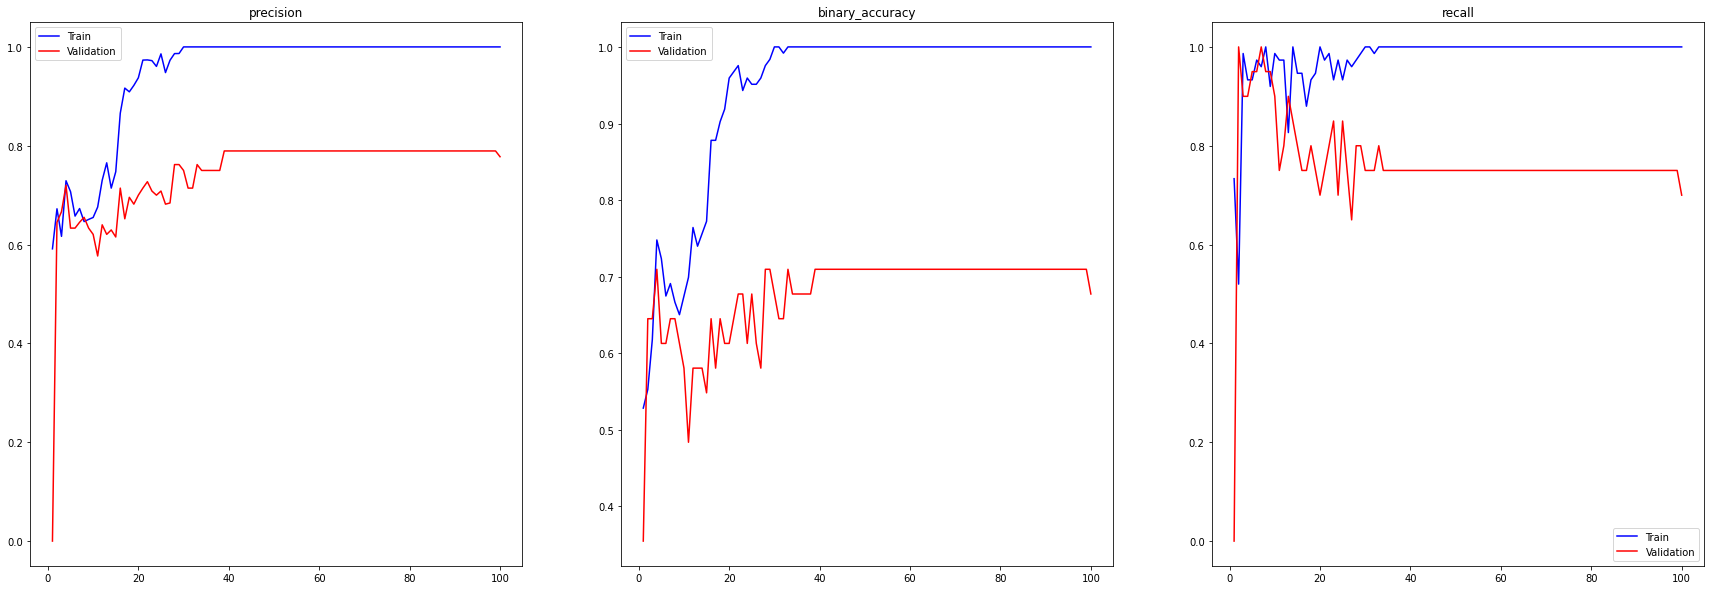

In [ ]:
metrics = ['precision', 'binary_accuracy', 'recall']
graph_history(df_le_net_5, metrics)

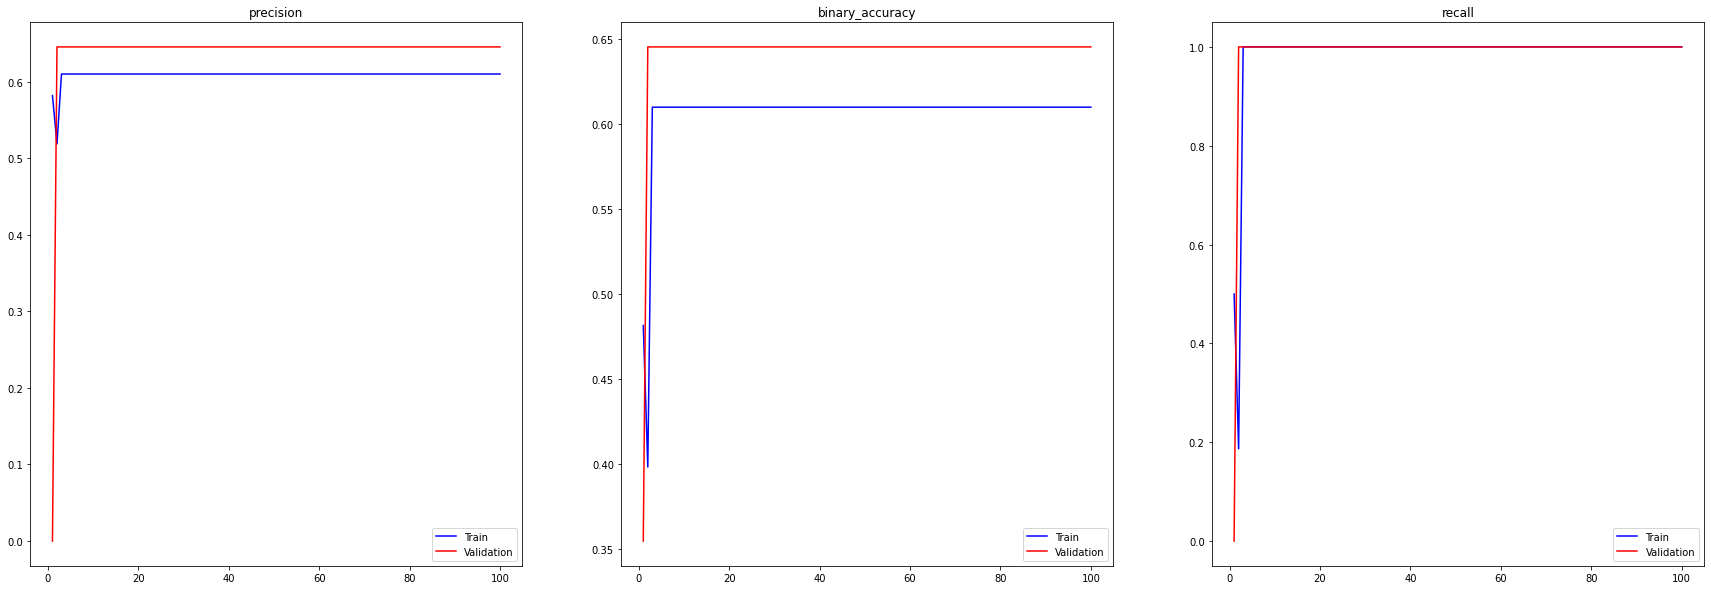

In [ ]:
graph_history(df_lu_net, metrics)

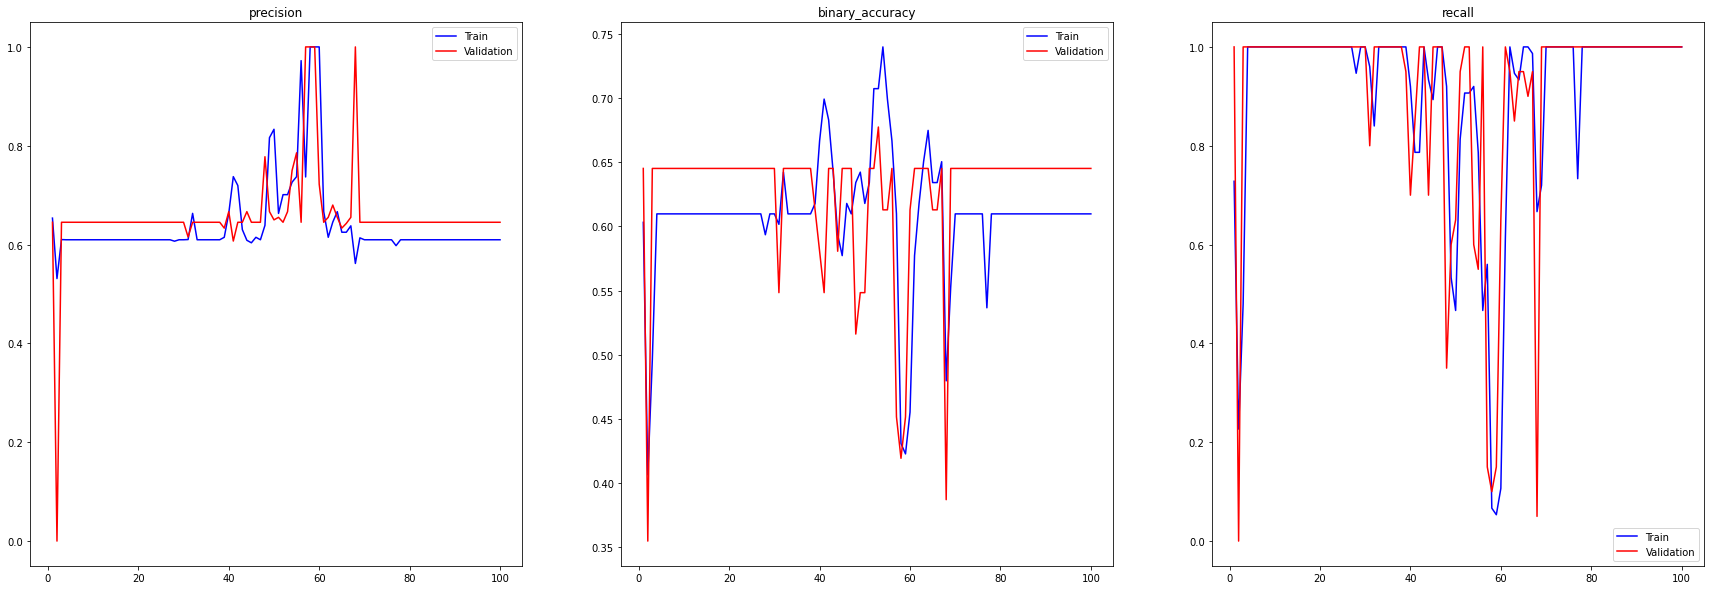

In [ ]:
graph_history(df_vgg_16, metrics)

In [ ]:
scores = [scores_le_net, scores_vgg_16, scores_lu_net]
losses, precisions = [score[0] for score in scores], [score[1] for score in scores]
bin_accs, recalls = [score[2] for score in scores], [score[3] for score in scores]
scores_df = pd.DataFrame({
    'Loss':losses, 
    'Precision':precisions,
    'Binary Accuracy':bin_accs,
    'Recall':recalls
})
scores_df.head()

NameError: name 'scores_lu_net' is not defined

In [ ]:
RES_PATH = './results'
scores_df.to_csv(f'{RES_PATH}/test_scores_1.csv')
df_le_net_5.to_csv(f'{RES_PATH}/le_net_5_metrics_1.csv')
df_vgg_16.to_csv(f'{RES_PATH}/vgg_16_metrics_1.csv')
df_lu_net.to_csv(f'{RES_PATH}/lu_net_metrics_1.csv')

## DATA AUGMENTATION

In [ ]:
imgs_trans = A.Compose([
    A.HorizontalFlip(p=0.25),
    A.VerticalFlip(p=0.25),
    A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), p=0.25),
    A.Rotate(limit=[-15, 15], p=0.25, border_mode=cv2.BORDER_CONSTANT),
    A.Affine(translate_percent=(-0.05, 0.05))
])

X_aug, y_aug = data_augmentation(X, classes, 20, imgs_trans)

In [ ]:
N, SIZE_H, SIZE_V = X_aug.shape
N_CLASSES = len(np.unique(y_aug))
print(f'X shape {X_aug.shape}')
print(f'Num classes: {N_CLASSES}')

In [ ]:
sd = seed(time())
X_train, X_test, y_train, y_test = train_test_split(X, classes, test_size=0.3, random_state=sd, shuffle=True)

In [ ]:
res_le_net, scores_le_net = fit_evaluate(le_net_5, X_train, X_test, y_train, y_test)

In [ ]:
res_vgg_16, scores_vgg_16 = fit_evaluate(vgg_16, X_train, X_test, y_train, y_test)

In [ ]:
res_lu_net, scores_lu_net = fit_evaluate(lu_net, X_train, X_test, y_train, y_test)

In [ ]:
df_lu_net = pd.DataFrame(res_lu_net.history)
df_lu_net.head()

In [ ]:
df_vgg_16 = pd.DataFrame(res_vgg_16.history)
df_lu_net.head()

In [ ]:
df_le_net_5 = pd.DataFrame(res_le_net.history)
df_le_net_5.head()

In [ ]:
metrics = ['precision', 'binary_accuracy', 'recall']
graph_history(df_le_net_5, metrics)

In [ ]:
graph_history(df_lu_net, metrics)

In [ ]:
graph_history(df_vgg_16, metrics)

In [ ]:
scores = [scores_le_net, scores_vgg_16, scores_lu_net]
losses, precisions = [score[0] for score in scores], [score[1] for score in scores]
bin_accs, recalls = [score[2] for score in scores], [score[3] for score in scores]
scores_df = pd.DataFrame({
    'Loss':losses, 
    'Precision':precisions,
    'Binary Accuracy':bin_accs,
    'Recall':recalls
})
scores_df.head()

In [ ]:
RES_PATH = './results'
scores_df.to_csv(f'{RES_PATH}/test_scores_2.csv')
df_le_net_5.to_csv(f'{RES_PATH}/le_net_5_metrics_2.csv')
df_vgg_16.to_csv(f'{RES_PATH}/vgg_16_metrics_2.csv')
df_lu_net.to_csv(f'{RES_PATH}/lu_net_metrics_2.csv')